<font color = blue><font size = 6> 실험설명 </font></font><br>
Seasonality 한주기를 임의 설정한후 moving average를 주기마다 겹치지 않게 해보겠다(Stride를 조정하겠다는 의미)<br>
여기서는 Linear layer하나에 한개의 trend가 들어가게 된다<br>
이것을 하는 이유는 DLinear에서 Decompose를 할때 moving average 자체에 어느정도의 seasonallity가 포함돼 있는거 같기 때문에 이를 더 엄격하게 구분하기 위해서 이다 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,MAPE,RMSE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


<AxesSubplot: >

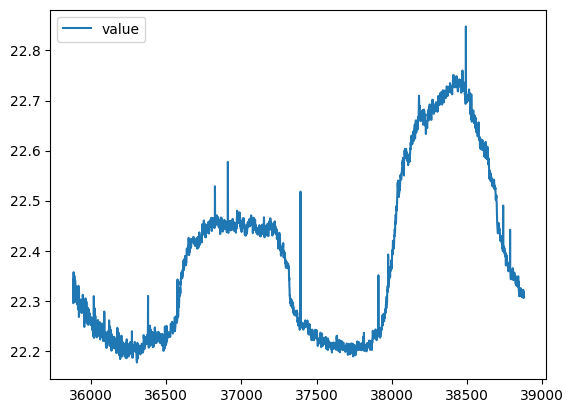

In [4]:
data[-3000:].plot() # 1일의 계절성이 있는것으로 판단된다

In [5]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModel2/online-learning-DLinear']

In [6]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [7]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size,stride):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size=kernel_size,stride=stride)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)
        x = x.permute(0,2,1)
        res = (x - moving_mean).permute(0,2,1)
        # Classical ma중에서 additive model
        return res,moving_mean

In [8]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25
        self.stride = 1440
        self.decomposition = series_decomp(kernel_size,self.stride)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        self.activation = nn.Tanh()
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len//self.stride,self.pred_len)) # 이렇게 설정하면 현재 상황에선 Layer당 Unit이 1개
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len//self.stride,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x/div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.to(self.device) 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x*div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_579792/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [11]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.99 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-04.


In [12]:
torch.manual_seed(42)

In [13]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

Adjusting learning rate of group 0 to 9.9000e-05.
smape 87.72845570804083 %
Adjusting learning rate of group 0 to 9.8010e-05.
smape 50.41414331622989 %
Adjusting learning rate of group 0 to 9.7030e-05.
smape 17.21215263907716 %
Adjusting learning rate of group 0 to 9.6060e-05.
smape 0.6291619230559429 %
Adjusting learning rate of group 0 to 9.5099e-05.
smape 0.33645754190548516 %
Adjusting learning rate of group 0 to 9.4148e-05.
smape 0.28466178374215195 %
Adjusting learning rate of group 0 to 9.3207e-05.
smape 0.34096322423194353 %
Adjusting learning rate of group 0 to 9.2274e-05.
smape 0.32445440273588977 %
Adjusting learning rate of group 0 to 9.1352e-05.
smape 0.29276377532177755 %
Adjusting learning rate of group 0 to 9.0438e-05.
smape 0.2871262724324108 %
Adjusting learning rate of group 0 to 8.9534e-05.
smape 0.2957451540012762 %
Adjusting learning rate of group 0 to 8.8638e-05.
smape 0.2927953389330974 %
Adjusting learning rate of group 0 to 8.7752e-05.
smape 0.2751468049348005

In [14]:
torch.manual_seed(42)

In [15]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [16]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []
PATH = './my/Online_Dlearning_Path'
for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.010092444803149192 %
SMAPE 0.013580933980847476 %
SMAPE 0.010717155733345862 %
SMAPE 0.010178668664707402 %
SMAPE 0.005533496569569252 %
SMAPE 0.005472721016531068 %
SMAPE 0.011492455625784714 %
SMAPE 0.004609145060840092 %
SMAPE 0.005130332921112313 %
SMAPE 0.005900138454762782 %
SMAPE 0.013016142507012773 %
SMAPE 0.0032588454038204873 %
SMAPE 0.005537776793445914 %
SMAPE 0.004106064469596049 %
SMAPE 0.0038404112967214137 %
SMAPE 0.014749021786428784 %
SMAPE 0.015399311953274264 %
SMAPE 0.007352235371286042 %
SMAPE 0.003925030834579957 %
SMAPE 0.00502857553746594 %
SMAPE 0.007958081097143577 %
SMAPE 0.004094667690310416 %
SMAPE 0.017875461378935142 %
SMAPE 0.008441828894717673 %
SMAPE 0.006192876287272497 %
SMAPE 0.00884040997948432 %
SMAPE 0.009952059812803782 %
SMAPE 0.013585657618932599 %
SMAPE 0.010726917785575552 %
SMAPE 0.012754232247971231 %
SMAPE 0.011978875641290188 %
SMAPE 0.003831375674621995 %
SMAPE 0.0024344033483103544 %
SMAPE 0.009990665553686995 %
SMAPE 0.01022

SMAPE 0.014744466740381768 %
SMAPE 0.010657904870271295 %
SMAPE 0.025251576911387016 %
SMAPE 0.03499020428557742 %
SMAPE 0.007376738250968628 %
SMAPE 0.012214346270411625 %
SMAPE 0.01027956049443901 %
SMAPE 0.004990296634872493 %
SMAPE 0.0038297524154060625 %
SMAPE 0.003908718794264132 %
SMAPE 0.009973776583080962 %
SMAPE 0.0063961595059822685 %
SMAPE 0.007709670528811329 %
SMAPE 0.007262508536314272 %
SMAPE 0.016458508981941122 %
SMAPE 0.00413787655742226 %
SMAPE 0.004272388071925093 %
SMAPE 0.005622879995371477 %
SMAPE 0.005014032701652127 %
SMAPE 0.002864088664082942 %
SMAPE 0.0025609599184690524 %
SMAPE 0.005439576531898638 %
SMAPE 0.007586948240714263 %
SMAPE 0.006596404495269326 %
SMAPE 0.010852326854390526 %
SMAPE 0.009624324964050857 %
SMAPE 0.01812599354644817 %
SMAPE 0.012750698385957548 %
SMAPE 0.0078097688784168895 %
SMAPE 0.010487506250456136 %
SMAPE 0.011772832895076135 %
SMAPE 0.007902848691173858 %
SMAPE 0.014579248304926294 %
SMAPE 0.026941058002080357 %
SMAPE 0.015712

SMAPE 0.006643039952166419 %
SMAPE 0.005234707782115322 %
SMAPE 0.010375070082773163 %
SMAPE 0.0092648437952505 %
SMAPE 0.009905713874331923 %
SMAPE 0.012579999245417639 %
SMAPE 0.010028075826426175 %
SMAPE 0.002899865218296327 %
SMAPE 0.009037202372269348 %
SMAPE 0.01041672551781403 %
SMAPE 0.020348689995508096 %
SMAPE 0.022344873356914263 %
SMAPE 0.01262741825244973 %
SMAPE 0.010400473002107447 %
SMAPE 0.006726943751800718 %
SMAPE 0.0065357293778234285 %
SMAPE 0.01002176561212309 %
SMAPE 0.0035589273059102307 %
SMAPE 0.004235512048580858 %
SMAPE 0.00548379950475919 %
SMAPE 0.00745269791912051 %
SMAPE 0.003723253885041799 %
SMAPE 0.0053038580782640565 %
SMAPE 0.005431017157100371 %
SMAPE 0.003667827845902139 %
SMAPE 0.00394001098550234 %
SMAPE 0.012349486783023167 %
SMAPE 0.007848267743611359 %
SMAPE 0.003916592945415687 %
SMAPE 0.00842868918118711 %
SMAPE 0.006061692076855252 %
SMAPE 0.00565621328121324 %
SMAPE 0.0031365775089966515 %
SMAPE 0.00868627493787244 %
SMAPE 0.0027571673763

SMAPE 0.006293634662029035 %
SMAPE 0.003449195338816935 %
SMAPE 0.02142303614023433 %
SMAPE 0.030381893080061673 %
SMAPE 0.004414441073549824 %
SMAPE 0.0048066024710351485 %
SMAPE 0.007122126924969052 %
SMAPE 0.009853898694700547 %
SMAPE 0.015794039727609288 %
SMAPE 0.011122577962282776 %
SMAPE 0.004895466073321586 %
SMAPE 0.005902532885670553 %
SMAPE 0.01193883725767364 %
SMAPE 0.005632907882997529 %
SMAPE 0.007129763139090528 %
SMAPE 0.007460788991664913 %
SMAPE 0.0044145932448032 %
SMAPE 0.004805837381177014 %
SMAPE 0.007933112337809689 %
SMAPE 0.010082401033514543 %
SMAPE 0.00900706246181926 %
SMAPE 0.01089935642198725 %
SMAPE 0.004712972795857695 %
SMAPE 0.004606072488883228 %
SMAPE 0.0035231360928378304 %
SMAPE 0.0062573504094984855 %
SMAPE 0.006582163646811522 %
SMAPE 0.004171006463707272 %
SMAPE 0.004316203073472025 %
SMAPE 0.002970796232148132 %
SMAPE 0.007206995886576806 %
SMAPE 0.007393258175270034 %
SMAPE 0.010347912331098996 %
SMAPE 0.01645630219582017 %
SMAPE 0.0109518096

SMAPE 0.007758766574625042 %
SMAPE 0.004466673402504284 %
SMAPE 0.006666412408236511 %
SMAPE 0.0014504663456591516 %
SMAPE 0.003442559219664076 %
SMAPE 0.006289294934049394 %
SMAPE 0.004453202727518146 %
SMAPE 0.015687181243265513 %
SMAPE 0.012600800447813752 %
SMAPE 0.005803556915452646 %
SMAPE 0.003814710510084751 %
SMAPE 0.010500351081738302 %
SMAPE 0.016397719059511928 %
SMAPE 0.006878300154198769 %
SMAPE 0.010376808139398008 %
SMAPE 0.010138069995832666 %
SMAPE 0.006073215755009187 %
SMAPE 0.0038076118847811813 %
SMAPE 0.004145785397852819 %
SMAPE 0.0026406508359286818 %
SMAPE 0.0075279245266131065 %
SMAPE 0.00963552838572923 %
SMAPE 0.009809710878812439 %
SMAPE 0.005157729946446921 %
SMAPE 0.004071615595442779 %
SMAPE 0.007307062969118761 %
SMAPE 0.005014973007746448 %
SMAPE 0.006137826794827106 %
SMAPE 0.004591166485035103 %
SMAPE 0.005351000940805761 %
SMAPE 0.00796131273722267 %
SMAPE 0.005838458136132374 %
SMAPE 0.00903091647438714 %
SMAPE 0.011723948247208682 %
SMAPE 0.00322

SMAPE 0.01332627925171437 %
SMAPE 0.005418653949448071 %
SMAPE 0.0038000996812570516 %
SMAPE 0.007108110838309756 %
SMAPE 0.013312776985145549 %
SMAPE 0.009348722696486789 %
SMAPE 0.007027704913951993 %
SMAPE 0.0147194332510594 %
SMAPE 0.010129088031646916 %
SMAPE 0.004440180405396177 %
SMAPE 0.008610831534610952 %
SMAPE 0.0190295469569719 %
SMAPE 0.014865428583789255 %
SMAPE 0.009790268293691895 %
SMAPE 0.005171286328732094 %
SMAPE 0.009156748566738315 %
SMAPE 0.004657196927723817 %
SMAPE 0.003727931764387904 %
SMAPE 0.007285752186362514 %
SMAPE 0.005223265166677038 %
SMAPE 0.00872105567248127 %
SMAPE 0.006454639803592953 %
SMAPE 0.006535096438540223 %
SMAPE 0.015639109778078364 %
SMAPE 0.011118125680468438 %
SMAPE 0.006230006791156484 %
SMAPE 0.009470108006325972 %
SMAPE 0.012263407843988718 %
SMAPE 0.009443730933639927 %
SMAPE 0.004595830458811179 %
SMAPE 0.0048950705477182055 %
SMAPE 0.007828898273317009 %
SMAPE 0.011646787160827898 %
SMAPE 0.005253741953140434 %
SMAPE 0.0035826481

SMAPE 0.00446099668693023 %
SMAPE 0.008320105016480284 %
SMAPE 0.009247849117997475 %
SMAPE 0.0026102032172730105 %
SMAPE 0.008334287935667817 %
SMAPE 0.007726188824221935 %
SMAPE 0.014949622486518876 %
SMAPE 0.00948503147901647 %
SMAPE 0.004307938978627135 %
SMAPE 0.0049195080955541926 %
SMAPE 0.004363876057219329 %
SMAPE 0.006160919684077725 %
SMAPE 0.005458158398710111 %
SMAPE 0.004932787146458395 %
SMAPE 0.008106792604223756 %
SMAPE 0.010280554460223357 %
SMAPE 0.013533072287316372 %
SMAPE 0.00901466926372052 %
SMAPE 0.0059023762328251905 %
SMAPE 0.0024185660626017125 %
SMAPE 0.002947111433002192 %
SMAPE 0.0058577498021463725 %
SMAPE 0.004639140993504043 %
SMAPE 0.004692402500950266 %
SMAPE 0.009153421304887388 %
SMAPE 0.0023385454001072503 %
SMAPE 0.006936294142839472 %
SMAPE 0.006679929685788011 %
SMAPE 0.013758922005855824 %
SMAPE 0.006566215109160112 %
SMAPE 0.008354924716741152 %
SMAPE 0.005141644870718665 %
SMAPE 0.010864185663706394 %
SMAPE 0.012904871428190745 %
SMAPE 0.007

SMAPE 0.03138947777571843 %
SMAPE 0.009515213241087395 %
SMAPE 0.003237577671143299 %
SMAPE 0.005666411695983697 %
SMAPE 0.0033104042814642303 %
SMAPE 0.0030356156746336183 %
SMAPE 0.01601721952037849 %
SMAPE 0.008641607995400591 %
SMAPE 0.004306800144149747 %
SMAPE 0.005885254457894007 %
SMAPE 0.007271493026451026 %
SMAPE 0.005377375029866016 %
SMAPE 0.0063266437126614505 %
SMAPE 0.0033412738146125776 %
SMAPE 0.0022860668797903827 %
SMAPE 0.011020233477822217 %
SMAPE 0.00901217327862014 %
SMAPE 0.008954916954600378 %
SMAPE 0.025596964434157595 %
SMAPE 0.017658509252584054 %
SMAPE 0.0056921482813336866 %
SMAPE 0.007736441169583941 %
SMAPE 0.002537389565986814 %
SMAPE 0.00431625977148542 %
SMAPE 0.004115143146009359 %
SMAPE 0.004413515345163432 %
SMAPE 0.005604512461218292 %
SMAPE 0.006128386275264575 %
SMAPE 0.001995964884258683 %
SMAPE 0.00701847055532312 %
SMAPE 0.002567157414148369 %
SMAPE 0.004539399473486583 %
SMAPE 0.0028374944367897115 %
SMAPE 0.004030600393662098 %
SMAPE 0.0025

SMAPE 0.0038758194566526068 %
SMAPE 0.013432217738682084 %
SMAPE 0.014567205037394615 %
SMAPE 0.010431711489189865 %
SMAPE 0.0019370202131909764 %
SMAPE 0.009396974210005737 %
SMAPE 0.007867064610934449 %
SMAPE 0.005545716999336037 %
SMAPE 0.007148425045365059 %
SMAPE 0.0041972085524548675 %
SMAPE 0.011061880072986696 %
SMAPE 0.0075625301728337035 %
SMAPE 0.0019254034358482388 %
SMAPE 0.005369535862428165 %
SMAPE 0.008217708458289508 %
SMAPE 0.00472763312046709 %
SMAPE 0.007477597761408105 %
SMAPE 0.0061312749930948485 %
SMAPE 0.0031310066090384225 %
SMAPE 0.0088095959841894 %
SMAPE 0.004215586642317248 %
SMAPE 0.003053687235308189 %
SMAPE 0.004293708238286342 %
SMAPE 0.00836945253797694 %
SMAPE 0.002780601711606323 %
SMAPE 0.014125772073384724 %
SMAPE 0.004884396554530213 %
SMAPE 0.0021271035248986436 %
SMAPE 0.006380942378257259 %
SMAPE 0.01785190702634054 %
SMAPE 0.013387492179390392 %
SMAPE 0.0016792075202758383 %
SMAPE 0.005260855597498448 %
SMAPE 0.004668027657999119 %
SMAPE 0.00

SMAPE 0.003915707103317345 %
SMAPE 0.009610929495408982 %
SMAPE 0.002630115548129197 %
SMAPE 0.0033613965271968027 %
SMAPE 0.003373787977892562 %
SMAPE 0.006995265701334574 %
SMAPE 0.005864906010486948 %
SMAPE 0.013365998077006225 %
SMAPE 0.005816302225241543 %
SMAPE 0.004139679153922771 %
SMAPE 0.005473958433498183 %
SMAPE 0.004234234263051917 %
SMAPE 0.00394829371839478 %
SMAPE 0.00848208193639266 %
SMAPE 0.007642117887428412 %
SMAPE 0.0064418799846066585 %
SMAPE 0.004209465218366404 %
SMAPE 0.0026232695115027127 %
SMAPE 0.0033066764287355 %
SMAPE 0.009976655774948995 %
SMAPE 0.013715268406222947 %
SMAPE 0.009271593627545371 %
SMAPE 0.015880188402327633 %
SMAPE 0.004841040145890929 %
SMAPE 0.004654335858504055 %
SMAPE 0.005858486364246573 %
SMAPE 0.01872560223000619 %
SMAPE 0.0173500338029271 %
SMAPE 0.007558487314767603 %
SMAPE 0.003298369850000427 %
SMAPE 0.009725936977702077 %
SMAPE 0.007506563638628449 %
SMAPE 0.0043915026043350736 %
SMAPE 0.004323838888268483 %
SMAPE 0.007530392

SMAPE 0.004889606078847919 %
SMAPE 0.0025610005842509054 %
SMAPE 0.006036974765720515 %
SMAPE 0.0024041294644234767 %
SMAPE 0.002537969089530634 %
SMAPE 0.007313756134635696 %
SMAPE 0.0035930875756093883 %
SMAPE 0.0032633620143087683 %
SMAPE 0.0038305853767610647 %
SMAPE 0.009519041193811972 %
SMAPE 0.01346778713536878 %
SMAPE 8.01292221993208 %
SMAPE 9.78452593833208 %
SMAPE 9.683403737843037 %
SMAPE 12.668012619018555 %
SMAPE 1.857983256690204 %
SMAPE 0.1108994047908709 %
SMAPE 4.394516501575708 %
SMAPE 1.7635184223763645 %
SMAPE 0.36796442300419585 %
SMAPE 0.011878129248827918 %
SMAPE 0.016086425975345264 %
SMAPE 0.00520564469979945 %
SMAPE 0.0310975486049756 %
SMAPE 0.006406779599217316 %
SMAPE 0.02535880874927443 %
SMAPE 0.027370497974402493 %
SMAPE 0.016303854410637086 %
SMAPE 0.04199880413302992 %
SMAPE 0.030175533437841295 %
SMAPE 0.03254677178895804 %
SMAPE 0.03146135172091391 %
SMAPE 0.06321510993006996 %
SMAPE 0.02873215605450241 %
SMAPE 0.008844471899294604 %
SMAPE 0.002765

SMAPE 0.04256790715534464 %
SMAPE 0.012758458788368897 %
SMAPE 0.00406322956551719 %
SMAPE 0.020068980645191914 %
SMAPE 0.005068837341582366 %
SMAPE 0.032875079073733104 %
SMAPE 0.010643248945939376 %
SMAPE 0.008856214109016491 %
SMAPE 0.019787898220997135 %
SMAPE 0.004027237053378485 %
SMAPE 0.0030318102975286365 %
SMAPE 0.0050825933180931315 %
SMAPE 0.008365367552414682 %
SMAPE 0.004984858353964228 %
SMAPE 0.017400868146694393 %
SMAPE 0.014552314609943549 %
SMAPE 0.007565552058849789 %
SMAPE 0.004619474009643909 %
SMAPE 0.017490165620330345 %
SMAPE 0.041685118514010355 %
SMAPE 0.0081755090200204 %
SMAPE 0.008444292283911636 %
SMAPE 0.0068814113487860595 %
SMAPE 0.013076029734861548 %
SMAPE 0.03473866815673432 %
SMAPE 0.002617769898961342 %
SMAPE 0.005424277460974736 %
SMAPE 0.010669488129167348 %
SMAPE 0.010972156902084862 %
SMAPE 0.00838899375503388 %
SMAPE 0.002614852151914704 %
SMAPE 0.010487704203910653 %
SMAPE 0.05654703265037143 %
SMAPE 0.00577244966575563 %
SMAPE 0.00902119866

SMAPE 0.025315359469715307 %
SMAPE 0.007088432829050362 %
SMAPE 0.008578949776619993 %
SMAPE 0.006518638024729739 %
SMAPE 0.006375091866743787 %
SMAPE 0.00918960537728708 %
SMAPE 0.006810646807949183 %
SMAPE 0.010002914081212566 %
SMAPE 0.06454459481284403 %
SMAPE 0.03382082721444135 %
SMAPE 0.032420792322682246 %
SMAPE 0.030274609983379722 %
SMAPE 0.023155077770525168 %
SMAPE 0.021755364312923575 %
SMAPE 0.011704125338283689 %
SMAPE 0.04374899790030895 %
SMAPE 0.03661956440129899 %
SMAPE 0.007660426950252486 %
SMAPE 0.017339343447027034 %
SMAPE 0.012264197808747213 %
SMAPE 0.040755257984869786 %
SMAPE 0.020455777261076946 %
SMAPE 0.0373742205997587 %
SMAPE 0.026035595527957867 %
SMAPE 0.03341967444413285 %
SMAPE 0.0048269252681620856 %
SMAPE 0.005166439674326284 %
SMAPE 0.0066029846982758045 %
SMAPE 0.0378596970297167 %
SMAPE 0.005083756019729435 %
SMAPE 0.02457429072552486 %
SMAPE 0.025180134954354116 %
SMAPE 0.008380051619511164 %
SMAPE 0.006529702260088754 %
SMAPE 0.028573965570330

SMAPE 0.016502011147395024 %
SMAPE 0.028868419687853475 %
SMAPE 0.029190465402450627 %
SMAPE 0.01066857120702025 %
SMAPE 0.014084430381871014 %
SMAPE 0.010727921456179956 %
SMAPE 0.01754575094429356 %
SMAPE 0.013999906791923422 %
SMAPE 0.014349567287737841 %
SMAPE 0.023861269760573123 %
SMAPE 0.04640601094206431 %
SMAPE 0.0056413918662485685 %
SMAPE 0.006850553456786201 %
SMAPE 0.04278546827424634 %
SMAPE 0.003748870148626793 %
SMAPE 0.01234854391054796 %
SMAPE 0.0082308234671018 %
SMAPE 0.006315431626035207 %
SMAPE 0.0295875467110136 %
SMAPE 0.0027327180850988952 %
SMAPE 0.005242556841267287 %
SMAPE 0.005240773356717909 %
SMAPE 0.024175169369925698 %
SMAPE 0.013648800485270838 %
SMAPE 0.03209172867026666 %
SMAPE 0.002316278935268201 %
SMAPE 0.008361595173653313 %
SMAPE 0.007144021624043262 %
SMAPE 0.01597141716825945 %
SMAPE 0.006333580772206915 %
SMAPE 0.007854318714350939 %
SMAPE 0.01272958502794097 %
SMAPE 0.004255105001917059 %
SMAPE 0.013539575199715161 %
SMAPE 0.0096836279491299

SMAPE 0.00683603827656043 %
SMAPE 0.023746631739868462 %
SMAPE 0.017160534570464847 %
SMAPE 0.02076189454692212 %
SMAPE 0.018053850641287283 %
SMAPE 0.010098172676862305 %
SMAPE 0.005165779314438623 %
SMAPE 0.0364161604381934 %
SMAPE 0.003010898320340516 %
SMAPE 0.01598269800467733 %
SMAPE 0.0276716889063664 %
SMAPE 0.009825209320752037 %
SMAPE 0.020095714001172382 %
SMAPE 0.016647903289879196 %
SMAPE 0.030040946310009527 %
SMAPE 0.015059475793805177 %
SMAPE 0.023889728564917334 %
SMAPE 0.013443092410739155 %
SMAPE 0.018538197044051685 %
SMAPE 0.018753186553567502 %
SMAPE 0.06499514241039606 %
SMAPE 0.00952630503564933 %
SMAPE 0.003888579317106178 %
SMAPE 0.005160647205684654 %
SMAPE 0.01974812760632716 %
SMAPE 0.0073760568883187725 %
SMAPE 0.014285760038575289 %
SMAPE 0.01388915475899921 %
SMAPE 0.007145134065943638 %
SMAPE 0.006506977649166857 %
SMAPE 0.017532724554257584 %
SMAPE 0.011389758956667606 %
SMAPE 0.010666363235145582 %
SMAPE 0.008851957518857034 %
SMAPE 0.0474621901689715

SMAPE 0.007677636651806096 %
SMAPE 0.030330053523243805 %
SMAPE 0.008039003502290143 %
SMAPE 0.08880666634536283 %
SMAPE 0.02105311743095939 %
SMAPE 0.010318061960340685 %
SMAPE 0.005481646158841613 %
SMAPE 0.026217749840270702 %
SMAPE 0.0594272629783461 %
SMAPE 0.108370843619241 %
SMAPE 0.022587737650788142 %
SMAPE 0.045152309947752656 %
SMAPE 0.010089693863960747 %
SMAPE 0.1134771769285976 %
SMAPE 0.06926338200901228 %
SMAPE 0.012641648238059133 %
SMAPE 0.12819636037420423 %
SMAPE 0.07699444761783525 %
SMAPE 0.13177166661262163 %
SMAPE 0.20765491564156946 %
SMAPE 0.043509017850169585 %
SMAPE 0.08510948129566032 %
SMAPE 0.7024602542442153 %
SMAPE 0.35285345089596376 %
SMAPE 0.06310195562036824 %
SMAPE 0.09343277315292653 %
SMAPE 0.023889911317610313 %
SMAPE 0.051740741381934185 %
SMAPE 0.03898818329841447 %
SMAPE 0.20376500602696979 %
SMAPE 0.055771528159311856 %
SMAPE 0.010464261896999005 %
SMAPE 0.011799477786439638 %
SMAPE 0.005530968065727393 %
SMAPE 0.00446047843706765 %
SMAPE 0.

SMAPE 0.01361066036605507 %
SMAPE 0.009344241707097467 %
SMAPE 0.007307702721789156 %
SMAPE 0.010366034804974333 %
SMAPE 0.016879522415820247 %
SMAPE 0.027458467797032426 %
SMAPE 0.04941484745540947 %
SMAPE 0.023081940191360673 %
SMAPE 0.005130420979298833 %
SMAPE 0.022227260434590335 %
SMAPE 0.005618070344212356 %
SMAPE 0.004102918040302939 %
SMAPE 0.010882346477160354 %
SMAPE 0.3310399872243579 %
SMAPE 0.01982243865768396 %
SMAPE 0.027392641589472074 %
SMAPE 0.033022369975014954 %
SMAPE 0.057596619225932955 %
SMAPE 0.007642053783541768 %
SMAPE 0.01235720299064269 %
SMAPE 0.003976537341983999 %
SMAPE 0.01410819858915602 %
SMAPE 0.0033818656508515237 %
SMAPE 0.012485669836323154 %
SMAPE 0.00959494237281433 %
SMAPE 0.0117180439015101 %
SMAPE 0.009987088780235354 %
SMAPE 0.03753327073980017 %
SMAPE 0.24266775294245235 %
SMAPE 0.027883115042641293 %
SMAPE 0.03223987653728955 %
SMAPE 0.045607471552671086 %
SMAPE 0.43157985916661806 %
SMAPE 0.2086418465451061 %
SMAPE 0.22473912282512742 %
S

SMAPE 0.00840251743625231 %
SMAPE 0.01749412063504252 %
SMAPE 0.016619243393051875 %
SMAPE 0.00387698327557473 %
SMAPE 0.013140905441261452 %
SMAPE 0.03236284835031711 %
SMAPE 0.006203379867486092 %
SMAPE 0.024915751589560386 %
SMAPE 0.008741041244320513 %
SMAPE 0.008263121467507517 %
SMAPE 0.006293960818595679 %
SMAPE 0.020382342038317347 %
SMAPE 0.020987134728699175 %
SMAPE 0.02062291006535588 %
SMAPE 0.02317036605654721 %
SMAPE 0.012126188096203805 %
SMAPE 0.013156375185808145 %
SMAPE 0.008858988293923176 %
SMAPE 0.00956365700969286 %
SMAPE 0.013884890752990486 %
SMAPE 0.003684198535893301 %
SMAPE 0.005346243723579391 %
SMAPE 0.010215416464916416 %
SMAPE 0.00894539206432654 %
SMAPE 0.008803174489798948 %
SMAPE 0.006973961834802367 %
SMAPE 0.009988312827317714 %
SMAPE 0.013955660668216296 %
SMAPE 0.023815449033335767 %
SMAPE 0.02402469180759681 %
SMAPE 0.015166691156224488 %
SMAPE 0.009788166665657627 %
SMAPE 0.006545834993517019 %
SMAPE 0.02850395272622563 %
SMAPE 0.0152347096823746

SMAPE 0.037958154083497675 %
SMAPE 0.02943725750867543 %
SMAPE 0.05532514315549974 %
SMAPE 0.12722147410258344 %
SMAPE 0.042095859638834554 %
SMAPE 0.031643198409824436 %
SMAPE 0.05877991901320456 %
SMAPE 0.3269825667321129 %
SMAPE 0.0880194472911171 %
SMAPE 0.17641445205538275 %
SMAPE 0.058169427703660403 %
SMAPE 0.1339263756752871 %
SMAPE 0.15502839163571025 %
SMAPE 0.011471776315318039 %
SMAPE 0.06892613471029563 %
SMAPE 0.039427952549658585 %
SMAPE 0.04099224420497194 %
SMAPE 0.14402743839286813 %
SMAPE 0.1620299072250475 %
SMAPE 0.02048843412575252 %
SMAPE 0.15725537554635594 %
SMAPE 0.17390059536160152 %
SMAPE 0.02339458548328821 %
SMAPE 0.14565550932184124 %
SMAPE 0.03524545164657411 %
SMAPE 0.2476882263399602 %
SMAPE 0.018160530381464923 %
SMAPE 0.03935662396213502 %
SMAPE 0.07689698883081064 %
SMAPE 0.014062420724314961 %
SMAPE 0.0038603734517721477 %
SMAPE 0.050020873203720846 %
SMAPE 0.022295175886625884 %
SMAPE 0.07734485860294171 %
SMAPE 0.08623081716370962 %
SMAPE 0.04276

SMAPE 0.04382197222807349 %
SMAPE 0.005654663457221432 %
SMAPE 0.0069445427297694096 %
SMAPE 0.016610482850111907 %
SMAPE 0.022957579089990077 %
SMAPE 0.0035431653878106317 %
SMAPE 0.031067993004057826 %
SMAPE 0.006419654081298632 %
SMAPE 0.009330727169412967 %
SMAPE 0.007857493786218583 %
SMAPE 0.023260120679879037 %
SMAPE 0.005763045336152572 %
SMAPE 0.0031973839393231174 %
SMAPE 0.010094022425874982 %
SMAPE 0.00716721059370684 %
SMAPE 0.010503361524058619 %
SMAPE 0.01928602115063427 %
SMAPE 0.005759081015867196 %
SMAPE 0.05202391887257818 %
SMAPE 0.03893712445028541 %
SMAPE 0.013836057718776829 %
SMAPE 0.007075223694300802 %
SMAPE 0.004219751161883778 %
SMAPE 0.003649898000205099 %
SMAPE 0.006935313394023979 %
SMAPE 0.010637368188781693 %
SMAPE 0.009307216341994717 %
SMAPE 0.028734349669989 %
SMAPE 0.002309730140297006 %
SMAPE 0.03317982686525056 %
SMAPE 0.014774663022308234 %
SMAPE 0.012527670837300775 %
SMAPE 0.010863722613805749 %
SMAPE 0.004478633741825888 %
SMAPE 0.002363332012

SMAPE 0.015087326488355757 %
SMAPE 0.015817818459993305 %
SMAPE 0.004741903209634302 %
SMAPE 0.015380633129552734 %
SMAPE 0.006182482442000036 %
SMAPE 0.01101107419708569 %
SMAPE 0.012100609520416583 %
SMAPE 0.031193967941362644 %
SMAPE 0.006751544148471567 %
SMAPE 0.009093012034554704 %
SMAPE 0.030781229270814947 %
SMAPE 0.031445690521763936 %
SMAPE 0.020541144999981498 %
SMAPE 0.03127771941881008 %
SMAPE 0.002808565430811427 %
SMAPE 0.010014558091711478 %
SMAPE 0.02675702149282699 %
SMAPE 0.0048328282932743605 %
SMAPE 0.04978606760533921 %
SMAPE 0.0262875840360266 %
SMAPE 0.029162633094870216 %
SMAPE 0.025094253978579673 %
SMAPE 0.011110040825087708 %
SMAPE 0.010272671963150515 %
SMAPE 0.03562894184801735 %
SMAPE 0.012434077224270366 %
SMAPE 0.02261786587462211 %
SMAPE 0.006922754376581963 %
SMAPE 0.006287226878853858 %
SMAPE 0.015447502182496464 %
SMAPE 0.015172291497947299 %
SMAPE 0.011087085594454038 %
SMAPE 0.0052162005129972044 %
SMAPE 0.004152264865268762 %
SMAPE 0.049600449704

SMAPE 0.004735165606227554 %
SMAPE 0.01934937597008002 %
SMAPE 0.01839221661884949 %
SMAPE 0.030377948826981083 %
SMAPE 0.02132208255147816 %
SMAPE 0.006924325110048812 %
SMAPE 0.011047499406686256 %
SMAPE 0.009299275568537269 %
SMAPE 0.008881529570203384 %
SMAPE 0.010464057856779618 %
SMAPE 0.03493209473003844 %
SMAPE 0.04081493139325687 %
SMAPE 0.0264599617123622 %
SMAPE 0.01044617657905178 %
SMAPE 0.07272052158168663 %
SMAPE 0.02172449968679757 %
SMAPE 0.012979660415510352 %
SMAPE 0.004565213351497732 %
SMAPE 0.049346098582645936 %
SMAPE 0.009243315341365133 %
SMAPE 0.015032532361544781 %
SMAPE 0.02260452809482416 %
SMAPE 0.013506873905299699 %
SMAPE 0.00477367076621249 %
SMAPE 0.009969630464411239 %
SMAPE 0.004117009542710548 %
SMAPE 0.004918495587773464 %
SMAPE 0.04316952394663076 %
SMAPE 0.00504826622670862 %
SMAPE 0.025385855706559823 %
SMAPE 0.021164609684149127 %
SMAPE 0.013681145536466486 %
SMAPE 0.011943746756372775 %
SMAPE 0.0077445810875929055 %
SMAPE 0.04112308331863801 %

SMAPE 0.008628117641364952 %
SMAPE 0.00740347383985096 %
SMAPE 0.0034834669297652003 %
SMAPE 0.01216788711423078 %
SMAPE 0.01682265661133897 %
SMAPE 0.0066922617227760375 %
SMAPE 0.01745936433189854 %
SMAPE 0.02218047307451343 %
SMAPE 0.016494091057040805 %
SMAPE 0.0037760064678025174 %
SMAPE 0.019180423654631795 %
SMAPE 0.02480953039562195 %
SMAPE 0.005423164788908252 %
SMAPE 0.006394072293915087 %
SMAPE 0.016411298474395153 %
SMAPE 0.003530757355747482 %
SMAPE 0.004442631865373414 %
SMAPE 0.02951842327752274 %
SMAPE 0.0062521091576854815 %
SMAPE 0.00544001178286635 %
SMAPE 0.03857023963428219 %
SMAPE 0.021354867506943265 %
SMAPE 0.006309981798267472 %
SMAPE 0.004037652106148926 %
SMAPE 0.005446244075358209 %
SMAPE 0.0013560991786647492 %
SMAPE 0.011540956988767448 %
SMAPE 0.02018192348967318 %
SMAPE 0.01023791351235559 %
SMAPE 0.006524701390503651 %
SMAPE 0.010413413837341068 %
SMAPE 0.015266644322991851 %
SMAPE 0.010423139054211106 %
SMAPE 0.014673990920613278 %
SMAPE 0.011081370204

SMAPE 0.006484616755642492 %
SMAPE 0.008975451100951659 %
SMAPE 0.010118827616679482 %
SMAPE 0.008747863211397089 %
SMAPE 0.002287707096400027 %
SMAPE 0.02872289560774277 %
SMAPE 0.01262468541517592 %
SMAPE 0.009145165871018435 %
SMAPE 0.005795738017525309 %
SMAPE 0.01683897699285808 %
SMAPE 0.019918992082153864 %
SMAPE 0.003392136092116971 %
SMAPE 0.006571582483047678 %
SMAPE 0.01612994643892307 %
SMAPE 0.024306635366116325 %
SMAPE 0.003406430902288093 %
SMAPE 0.01322887005497364 %
SMAPE 0.0051558946566956365 %
SMAPE 0.012472808372706368 %
SMAPE 0.004276377601740933 %
SMAPE 0.018408099022821034 %
SMAPE 0.009163043582759656 %
SMAPE 0.003499206217213668 %
SMAPE 0.00567156433078253 %
SMAPE 0.017629486960061058 %
SMAPE 0.02808043432719387 %
SMAPE 0.005291054624080971 %
SMAPE 0.024852610238880857 %
SMAPE 0.015903836093798418 %
SMAPE 0.004183390049860236 %
SMAPE 0.008294661335185083 %
SMAPE 0.015808380942871736 %
SMAPE 0.00546294334895947 %
SMAPE 0.03344124266564563 %
SMAPE 0.01890194459888

SMAPE 0.006579582223395164 %
SMAPE 0.01916775859393738 %
SMAPE 0.007240952028013226 %
SMAPE 0.003117964101306825 %
SMAPE 0.011238788406046751 %
SMAPE 0.011133849508944138 %
SMAPE 0.01698206864580243 %
SMAPE 0.0074881759101117495 %
SMAPE 0.004006405270956748 %
SMAPE 0.0032293353011709765 %
SMAPE 0.012835988459769965 %
SMAPE 0.007237227264056401 %
SMAPE 0.010024768727362243 %
SMAPE 0.005518373822525291 %
SMAPE 0.004524153092013705 %
SMAPE 0.0033640341216596426 %
SMAPE 0.00966437814028609 %
SMAPE 0.004849744678779189 %
SMAPE 0.0038237348098490997 %
SMAPE 0.0028717046389488132 %
SMAPE 0.0030342501922291376 %
SMAPE 0.004755665962505873 %
SMAPE 0.008502106611913973 %
SMAPE 0.003014565167575256 %
SMAPE 0.007555182400778904 %
SMAPE 0.020243705567622783 %
SMAPE 0.011013668354308948 %
SMAPE 0.0027603732927374836 %
SMAPE 0.0038548218808003294 %
SMAPE 0.003124036982896428 %
SMAPE 0.005909486363179894 %
SMAPE 0.004819147023908954 %
SMAPE 0.00921347666701422 %
SMAPE 0.0020296472134759824 %
SMAPE 0.0

SMAPE 0.02314800828173702 %
SMAPE 0.018678280236372302 %
SMAPE 0.018441545299452855 %
SMAPE 0.005957574104343166 %
SMAPE 0.007293565351346843 %
SMAPE 0.01931150004935489 %
SMAPE 0.008915642659644618 %
SMAPE 0.00769396504733777 %
SMAPE 0.004971216974070103 %
SMAPE 0.007834443835520233 %
SMAPE 0.016845328130180803 %
SMAPE 0.012520238503725524 %
SMAPE 0.018910405750034442 %
SMAPE 0.00580645712405925 %
SMAPE 0.007984004472291417 %
SMAPE 0.0011030752811649336 %
SMAPE 0.010787384403847966 %
SMAPE 0.005585355303082906 %
SMAPE 0.0032028553376335367 %
SMAPE 0.003498229677006748 %
SMAPE 0.005849530270729986 %
SMAPE 0.004104196996649989 %
SMAPE 0.003614184334310267 %
SMAPE 0.01712160191750911 %
SMAPE 0.014837452515649828 %
SMAPE 0.0068289050707335255 %
SMAPE 0.009600413672160357 %
SMAPE 0.0055045100924076 %
SMAPE 0.007462092752746229 %
SMAPE 0.009556441060169618 %
SMAPE 0.022361600657006875 %
SMAPE 0.015611312178862136 %
SMAPE 0.015010113219830146 %
SMAPE 0.004107915839654197 %
SMAPE 0.0091209808

SMAPE 0.004826722736332556 %
SMAPE 0.014505415129974606 %
SMAPE 0.006323724236949602 %
SMAPE 0.013403005969848893 %
SMAPE 0.014113350632896982 %
SMAPE 0.010697766077669257 %
SMAPE 0.009004409939279867 %
SMAPE 0.010126676303116255 %
SMAPE 0.0019211438439015183 %
SMAPE 0.007396504084681509 %
SMAPE 0.015081445741884636 %
SMAPE 0.011618778410031894 %
SMAPE 0.007302094817305261 %
SMAPE 0.005414417055362719 %
SMAPE 0.005728847045233465 %
SMAPE 0.005095075143159988 %
SMAPE 0.0034600587852082754 %
SMAPE 0.006682944156295889 %
SMAPE 0.0035723343214613124 %
SMAPE 0.007858904647264353 %
SMAPE 0.005777209362008762 %
SMAPE 0.005223998259936025 %
SMAPE 0.0027821890626569257 %
SMAPE 0.013668138234606886 %
SMAPE 0.009577613217402359 %
SMAPE 0.008306434331075252 %
SMAPE 0.0070541047923669 %
SMAPE 0.002913153940198754 %
SMAPE 0.0035827150363729743 %
SMAPE 0.005577740380317664 %
SMAPE 0.011354693044040687 %
SMAPE 0.0033520757442246914 %
SMAPE 0.005033167807695804 %
SMAPE 0.01060143821314341 %
SMAPE 0.007

SMAPE 0.009705003446015326 %
SMAPE 0.0074799777499308115 %
SMAPE 0.0027325350388949232 %
SMAPE 0.0030021590905278117 %
SMAPE 0.003768639832003373 %
SMAPE 0.008629832691951833 %
SMAPE 0.0031322796691597436 %
SMAPE 0.008187919343981775 %
SMAPE 0.002389087469907736 %
SMAPE 0.017239258889617304 %
SMAPE 0.017603847391740146 %
SMAPE 0.0028966361061932844 %
SMAPE 0.0031685647748673777 %
SMAPE 0.0030679568364178063 %
SMAPE 0.01108154823816676 %
SMAPE 0.007236809838047976 %
SMAPE 0.015168835555158468 %
SMAPE 0.005668679295695256 %
SMAPE 0.00748433355289535 %
SMAPE 0.007955294987709749 %
SMAPE 0.007713507662629127 %
SMAPE 0.019148336103896213 %
SMAPE 0.006000020678584406 %
SMAPE 0.007647969891650064 %
SMAPE 0.005870352176060578 %
SMAPE 0.0047827797856712095 %
SMAPE 0.012449208975340298 %
SMAPE 0.003910197850018449 %
SMAPE 0.007350116908583004 %
SMAPE 0.005940025512131797 %
SMAPE 0.007104803422180338 %
SMAPE 0.007252786025730984 %
SMAPE 0.002449886613931085 %
SMAPE 0.0034651126356948225 %
SMAPE 0

SMAPE 0.012494191864107052 %
SMAPE 0.004664199280341563 %
SMAPE 0.013074234840473764 %
SMAPE 0.008669595580158784 %
SMAPE 0.002359425505034096 %
SMAPE 0.006298637915335803 %
SMAPE 0.0037013061034940615 %
SMAPE 0.0061027190329809855 %
SMAPE 0.0036339232870545857 %
SMAPE 0.003017133068738076 %
SMAPE 0.0021979205660613843 %
SMAPE 0.005325389634435851 %
SMAPE 0.0020524691724403965 %
SMAPE 0.005095985553495552 %
SMAPE 0.009019315129535244 %
SMAPE 0.0021571594736542465 %
SMAPE 0.0024402595331594057 %
SMAPE 0.0077677420565009925 %
SMAPE 0.008299117408284928 %
SMAPE 0.004998976313032699 %
SMAPE 0.0021017464823671617 %
SMAPE 0.003312445243999207 %
SMAPE 0.0026662808227513324 %
SMAPE 0.008814321529143854 %
SMAPE 0.005553565130838933 %
SMAPE 0.005053376637519591 %
SMAPE 0.005039286400233323 %
SMAPE 0.004155907733704112 %
SMAPE 0.011749907547709881 %
SMAPE 0.011835888242444526 %
SMAPE 0.005672164382986011 %
SMAPE 0.0013563284894644312 %
SMAPE 0.006587910853113499 %
SMAPE 0.011091563996131981 %
SMA

SMAPE 0.0027173031288043603 %
SMAPE 0.010644077994129475 %
SMAPE 0.0018493872183853455 %
SMAPE 0.0041899365767434915 %
SMAPE 0.0015012250919426151 %
SMAPE 0.004152957851601968 %
SMAPE 0.005092253194035834 %
SMAPE 0.00449093056795391 %
SMAPE 0.004224089180070223 %
SMAPE 0.002989631511681523 %
SMAPE 0.0041180381003869115 %
SMAPE 0.0020002487491410648 %
SMAPE 0.007432149666044551 %
SMAPE 0.006081984353613734 %
SMAPE 0.002945025254135203 %
SMAPE 0.004086268140667926 %
SMAPE 0.006766943595039265 %
SMAPE 0.007771788978658378 %
SMAPE 0.009431180879431622 %
SMAPE 0.0035832686363193034 %
SMAPE 0.005638880054625872 %
SMAPE 0.002124774407192831 %
SMAPE 0.004456464511569891 %
SMAPE 0.003936343859209046 %
SMAPE 0.004526892726346432 %
SMAPE 0.004030341513413305 %
SMAPE 0.0034889082927520576 %
SMAPE 0.002188869432671936 %
SMAPE 0.009144283275873022 %
SMAPE 0.011752964047786918 %
SMAPE 0.0029668879234350243 %
SMAPE 0.007665983549969723 %
SMAPE 0.0031984187692728483 %
SMAPE 0.005787422690900712 %
SMAPE

SMAPE 0.0031260380503681517 %
SMAPE 0.003917604003319752 %
SMAPE 0.0014674288172429328 %
SMAPE 0.010635670214782067 %
SMAPE 0.009734015614697 %
SMAPE 0.005915490531606338 %
SMAPE 0.006584171765723568 %
SMAPE 0.00619793807222635 %
SMAPE 0.004811562007439818 %
SMAPE 0.003941465975884739 %
SMAPE 0.0032291024843544842 %
SMAPE 0.0021198506638455683 %
SMAPE 0.0018776838074501256 %
SMAPE 0.009240060290835572 %
SMAPE 0.00394030960649161 %
SMAPE 0.0024163363281104466 %
SMAPE 0.006293142537224128 %
SMAPE 0.01598197774310961 %
SMAPE 0.012068504925650814 %
SMAPE 0.009819407651320944 %
SMAPE 0.0018468574534438176 %
SMAPE 0.004445947565955066 %
SMAPE 0.004293602538616881 %
SMAPE 0.00437174826492992 %
SMAPE 0.0041062931034900885 %
SMAPE 0.00218117540058671 %
SMAPE 0.003964675836215292 %
SMAPE 0.0050123691484600386 %
SMAPE 0.006120683699009533 %
SMAPE 0.002259163421967969 %
SMAPE 0.004841798085323035 %
SMAPE 0.004807684217524866 %
SMAPE 0.0014658848158433102 %
SMAPE 0.005593939231687273 %
SMAPE 0.0023

SMAPE 0.011210750820879412 %
SMAPE 0.0037018424673078694 %
SMAPE 0.004298433182199801 %
SMAPE 0.0071184600411271495 %
SMAPE 0.006493007119843242 %
SMAPE 0.01138862736036117 %
SMAPE 0.007166026113694101 %
SMAPE 0.0027977743677070066 %
SMAPE 0.0027411008813373883 %
SMAPE 0.006121478903423848 %
SMAPE 0.004443710865757566 %
SMAPE 0.0022937756420517985 %
SMAPE 0.003584461041896247 %
SMAPE 0.0034999013315939465 %
SMAPE 0.0017715629877557149 %
SMAPE 0.0020156064801994944 %
SMAPE 0.003937149234843673 %
SMAPE 0.003633951191886809 %
SMAPE 0.003850046670777374 %
SMAPE 0.0030363349397788397 %
SMAPE 0.006412934303170914 %
SMAPE 0.008924835028594202 %
SMAPE 0.006150638405870268 %
SMAPE 0.006810309086716869 %
SMAPE 0.003860180736978691 %
SMAPE 0.0033994116751898677 %
SMAPE 0.004264107038295606 %
SMAPE 0.005262499460684467 %
SMAPE 0.01475096944636789 %
SMAPE 0.009145549172529854 %
SMAPE 0.003981811091961163 %
SMAPE 0.006980273213628153 %
SMAPE 0.008660483722195522 %
SMAPE 0.0033461716742451135 %
SMAPE

SMAPE 0.0016647296573637502 %
SMAPE 0.004031319630598773 %
SMAPE 0.011336687260637746 %
SMAPE 0.011491281718804203 %
SMAPE 0.006005878385394681 %
SMAPE 0.0030589950176533875 %
SMAPE 0.004653715295702909 %
SMAPE 0.0024478014972544315 %
SMAPE 0.00338133679676389 %
SMAPE 0.008317943210158774 %
SMAPE 0.00910952114986685 %
SMAPE 0.01096050187842934 %
SMAPE 0.0075387713610552964 %
SMAPE 0.006806832403526642 %
SMAPE 0.002095690210957457 %
SMAPE 0.005390359556088242 %
SMAPE 0.0032870251868644122 %
SMAPE 0.003597187845912231 %
SMAPE 0.0013940436850248261 %
SMAPE 0.004131699924471377 %
SMAPE 0.010295923749964686 %
SMAPE 0.0934970632730483 %
SMAPE 0.18972248632900346 %
SMAPE 0.03026221139316476 %
SMAPE 0.001706147362710908 %
SMAPE 0.008468288171314953 %
SMAPE 0.006820521924680634 %
SMAPE 0.008169471358087321 %
SMAPE 0.006078036322975322 %
SMAPE 0.003784421003729221 %
SMAPE 0.0092497653823429 %
SMAPE 0.0019292868907427871 %
SMAPE 0.002522109576489129 %
SMAPE 0.007128935015657589 %
SMAPE 0.00290594

SMAPE 0.0100757717050044 %
SMAPE 0.005628656633007267 %
SMAPE 0.005262716255856503 %
SMAPE 0.0031790111435157087 %
SMAPE 0.003725800544344793 %
SMAPE 0.004526339667762613 %
SMAPE 0.0026445203506000325 %
SMAPE 0.0038453803773847994 %
SMAPE 0.010083077021135978 %
SMAPE 0.006266224871069426 %
SMAPE 0.008865890670563203 %
SMAPE 0.007918455090248244 %
SMAPE 0.008977587258314657 %
SMAPE 0.002576850742343595 %
SMAPE 0.008297243342553884 %
SMAPE 0.006558102947792577 %
SMAPE 0.0033547294178788434 %
SMAPE 0.005233418804323264 %
SMAPE 0.006376911304286636 %
SMAPE 0.004311749628755024 %
SMAPE 0.007788454825231383 %
SMAPE 0.006607515799430529 %
SMAPE 0.0037446043222360004 %
SMAPE 0.0059224701967792726 %
SMAPE 0.005837054615767556 %
SMAPE 0.008050689929632426 %
SMAPE 0.002427199447907924 %
SMAPE 0.0020534088439490006 %
SMAPE 0.004856998098141219 %
SMAPE 0.0048631732299782016 %
SMAPE 0.008767212353518516 %
SMAPE 0.0040796965800495855 %
SMAPE 0.005853979244875518 %
SMAPE 0.0031270076453893125 %
SMAPE 

SMAPE 0.00401026608155064 %
SMAPE 0.003751203995534524 %
SMAPE 0.00325334003792932 %
SMAPE 0.004538164041591131 %
SMAPE 0.004590824835077001 %
SMAPE 0.00784222972936277 %
SMAPE 0.00486975490241548 %
SMAPE 0.005171900279421493 %
SMAPE 0.005626275820077353 %
SMAPE 0.001914941628598399 %
SMAPE 0.006616480925913493 %
SMAPE 0.004970019013029514 %
SMAPE 0.01126075390806136 %
SMAPE 0.004721166148875966 %
SMAPE 0.003636531499864759 %
SMAPE 0.006335459355710782 %
SMAPE 0.011582554067203432 %
SMAPE 0.02544291350000094 %
SMAPE 0.036575665389705136 %
SMAPE 0.004947021510034233 %
SMAPE 0.011444882864452666 %
SMAPE 0.006896669186204463 %
SMAPE 0.0071328319193071366 %
SMAPE 0.004151087866148373 %
SMAPE 0.0050761799472667235 %
SMAPE 0.013454408826873987 %
SMAPE 0.008872047404324235 %
SMAPE 0.006367954230597661 %
SMAPE 0.007062572630303521 %
SMAPE 0.0036785763395528197 %
SMAPE 0.005146897727058786 %
SMAPE 0.005405235578507472 %
SMAPE 0.005426844383691787 %
SMAPE 0.008931674183969562 %
SMAPE 0.006867588

SMAPE 0.004340278462450442 %
SMAPE 0.005934777381867207 %
SMAPE 0.003297732061980696 %
SMAPE 0.0028790479979079464 %
SMAPE 0.0020119043406339188 %
SMAPE 0.008105751713628706 %
SMAPE 0.045030397514267406 %
SMAPE 0.12599184298846922 %
SMAPE 0.03918303345099616 %
SMAPE 0.010670387937352643 %
SMAPE 0.007669170706883221 %
SMAPE 0.007093512540194524 %
SMAPE 0.008155761227925495 %
SMAPE 0.0020649161526336 %
SMAPE 0.0064361718569898585 %
SMAPE 0.00916471209695402 %
SMAPE 0.0029468203613305377 %
SMAPE 0.0013081538313599594 %
SMAPE 0.0030685822039231425 %
SMAPE 0.006380690167020474 %
SMAPE 0.005453425705695736 %
SMAPE 0.0039116724597079156 %
SMAPE 0.005877533624698117 %
SMAPE 0.007763602768363853 %
SMAPE 0.012715828560317277 %
SMAPE 0.02214880710835132 %
SMAPE 0.014432272144013325 %
SMAPE 0.003997450318479423 %
SMAPE 0.007119037313714216 %
SMAPE 0.009073353844996745 %
SMAPE 0.008011044656107913 %
SMAPE 0.0073105979515730715 %
SMAPE 0.004254348509391548 %
SMAPE 0.00410657044983509 %
SMAPE 0.00399

In [17]:
len(pred_list)

10080

In [18]:
pred_list

[22.438051223754883,
 22.42812156677246,
 22.403900146484375,
 22.411710739135742,
 22.406341552734375,
 22.42140769958496,
 22.405994415283203,
 22.409988403320312,
 22.40209197998047,
 22.396957397460938,
 22.424768447875977,
 22.43016815185547,
 22.420391082763672,
 22.41470718383789,
 22.409557342529297,
 22.439781188964844,
 22.411861419677734,
 22.42437171936035,
 22.419065475463867,
 22.408967971801758,
 22.430282592773438,
 22.43417739868164,
 22.396625518798828,
 22.41040802001953,
 22.404521942138672,
 22.425447463989258,
 22.401872634887695,
 22.424867630004883,
 22.39537239074707,
 22.427024841308594,
 22.40212059020996,
 22.40872573852539,
 22.4119873046875,
 22.40554428100586,
 22.424571990966797,
 22.404661178588867,
 22.427169799804688,
 22.412410736083984,
 22.410064697265625,
 22.393388748168945,
 22.4008846282959,
 22.387187957763672,
 22.404132843017578,
 22.403682708740234,
 22.394424438476562,
 22.386566162109375,
 22.423412322998047,
 22.393630981445312,
 22.3928

In [19]:
target=list(target.values.reshape(-1))

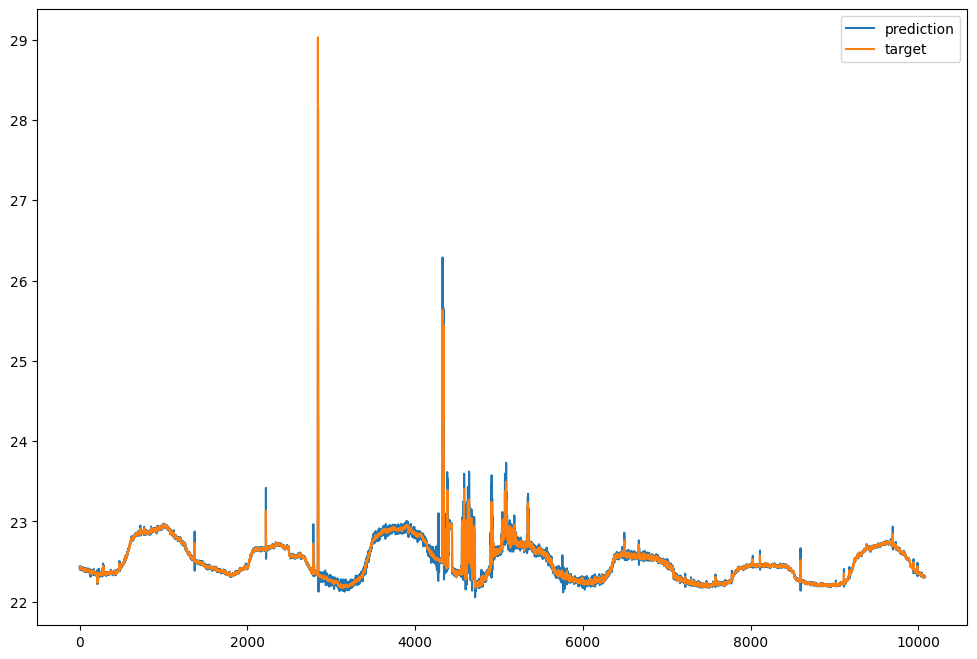

In [20]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [21]:
np.array(pred_list)

array([22.43805122, 22.42812157, 22.40390015, ..., 22.30230141,
       22.32190323, 22.30844307])

In [22]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[22.423888],
       [22.41452 ],
       [22.416   ],
       ...,
       [22.31816 ],
       [22.31004 ],
       [22.30716 ]])

In [23]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [24]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

SMAPE 0.10060673812404275 %
RMSE 0.08089574426412582
MAPE 0.10061851935461164 %


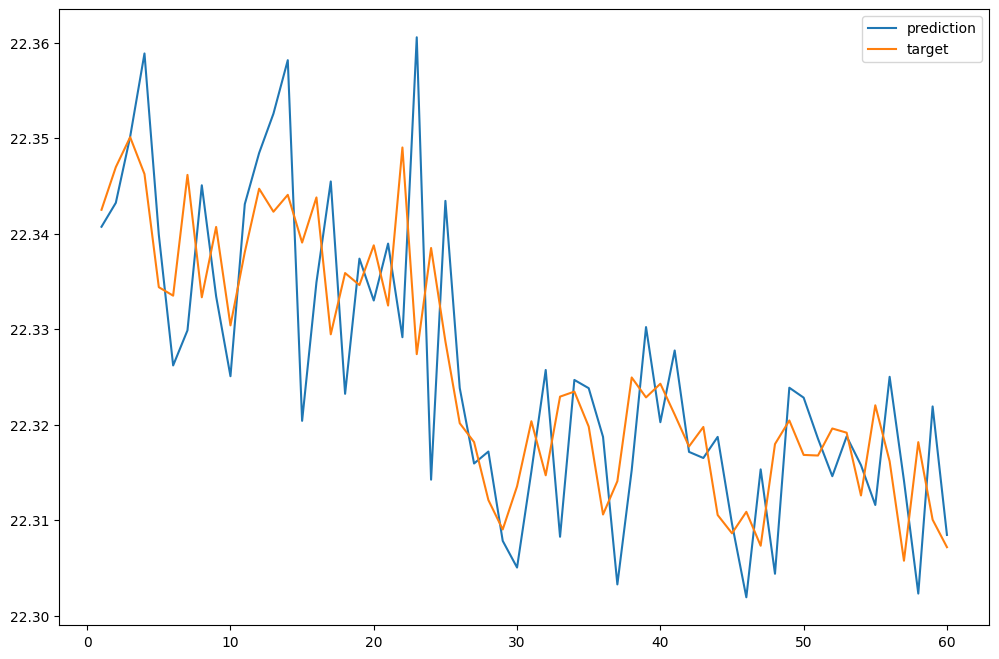

In [25]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [26]:
len(time_list)

10080

In [27]:
np.mean(time_list) 

0.4330249843379808

FIRST